# NBA Career Longevity Prediction: Machine Learning Classification Project

**Author:** Pierre Dal Bianco

## Project Overview

This notebook demonstrates a complete machine learning pipeline for predicting NBA player career longevity. The goal is to build a classifier that predicts whether a rookie NBA player will have a career lasting more than 5 years, based on their debut season statistics.

**Business Context:** This model is designed to assist sports investors in identifying promising NBA rookies worth investing in for long-term sponsorships and partnerships.

### 1. Imports and utility fonctions

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, accuracy_score, fbeta_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
import pickle

First we define a few utility functions

In [2]:
def score_classifier(dataset,classifier,labels):
    """
    Performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return: confusion_mat, recall, accuracy, fbeta
    """
    # added a pipeline to properly scale data
    # without the pipeline we would scale the train data set also based on information from the test data set
    pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])
    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    confusion_mat = np.zeros((2,2))
    recall = 0
    accuracy = 0
    fbeta = 0
    for training_ids,test_ids in kf.split(dataset):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]
        pipe.fit(training_set, training_labels)
        predicted_labels = pipe.predict(test_set)
        confusion_mat += confusion_matrix(test_labels, predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        # added accuracy and fbeta score
        accuracy += accuracy_score(test_labels, predicted_labels)
        fbeta += fbeta_score(test_labels, predicted_labels, beta=2)
    recall /= 3
    # added accuracy and fbeta scores
    accuracy /= 3
    fbeta /= 3
    # commented prints
    #print(confusion_mat)
    #print(recall)
    # added returns
    return confusion_mat, recall, accuracy, fbeta

def final_score_classifier(X_train, y_train, X_test, y_test, model):
    """
    Performs a training of our model on X_train/y_train and evaluates its scores on X_test/y_test
    :param X_train: the train features
    :param y_train: the train labels
    :param X_test: the test features
    :param y_test: the test labels
    :param model: the model to use
    :return: confusion_mat, recall, accuracy, fbeta
    """
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    confusion_mat = confusion_matrix(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    fbeta = fbeta_score(y_test, y_pred, beta=2)

    return confusion_mat, recall, accuracy, fbeta

def plot_confusion_mat(confusion_mat, title='Confusion matrix'):
    """
    Plots a confusion matrix using Seaborn
    :param confusion_mat: confusion matrix to plot
    :param title: optional : title of the plot
    """
    ax = sns.heatmap(confusion_mat/confusion_mat.sum(), vmin=0, vmax=1, annot=True, fmt='.2%', square=True)
    ax.set_title(title);
    ax.set_xlabel('true');
    ax.set_ylabel('predictions');


def plot_scores_param(dataset, estimator, labels, param_name, param_range, other_params={}):
    """
    Performs a grid search on a model on a single parameter and displays the scores vs parameter
    :param dataset: the dataset to work on
    :param estimator: the estimator to use
    :param labels: the labels used for training and validation
    :param param_name: the name of the parameter on which we perform the grid search
    :param param_range: the range of the parameter to perform the grid search
    :param other_params: optional: additional parameters to pass to the classifier
    """
    recall = []
    accuracy = []
    fbeta = []
    for p in param_range:
        _, rec, acc, fb = score_classifier(dataset, estimator(**{param_name:p}, **other_params), labels)
        recall.append(rec)
        accuracy.append(acc)
        fbeta.append(fb)
    best_param = np.argmax(recall)

    plt.figure(figsize=(10, 6));
    plt.plot(param_range, accuracy, label='accuracy score', color='royalblue', linestyle='dashed');
    plt.plot(param_range, fbeta, label='fbeta score', color='mediumpurple', linestyle='dashed');
    plt.plot(param_range, recall, label='recall score',  color='orange',);
    plt.scatter(param_range[best_param], recall[best_param], label='recall max', marker='x', s=100, color='red')
    plt.legend();
    plt.title(f'score = f({param_name})');
    plt.show();

    print(f'Value of {param_name}={param_range[best_param]} provides the best recall score={recall[best_param]:.2%}, accuracy={accuracy[best_param]:.2%}, fbeta={fbeta[best_param]:.2%}')

    confusion_mat, _, _, _ = score_classifier(dataset, estimator(**{param_name:param_range[best_param]}, **other_params), labels)
    plot_confusion_mat(confusion_mat, f'Confusion matrix for {param_name}={param_range[best_param]}')

# we create a DF to store the scores of our different classifiers
classifier_scores = pd.DataFrame(columns=['Classifieur', 'recall', 'accuracy', 'fbeta'])

### 2. Importing and cleaning our data set

We can now import our data set

In [19]:
# Load dataset
df = pd.read_csv("../data/nba_logreg.csv")

Let's check the dataset shape and look for any duplicate entries.

In [20]:
# Check dataset shape
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(df.columns) - 2}")  # excluding Name and TARGET_5Yrs

# Check for duplicates
duplicates = df.duplicated(keep=False)
n_duplicates = duplicates.sum()
n_duplicate_names = df.duplicated(subset="Name").sum()

print(f"\nNumber of duplicate player names: {n_duplicate_names}")
print(f"Number of duplicate rows: {n_duplicates}")

if n_duplicates == 0:
    print("No duplicate rows found in the dataset.")

Number of samples: 1340
Number of features: 19

Number of duplicate player names: 46
Number of duplicate rows: 24


#### Data Cleaning: Handling Duplicates

Based on our analysis:
- **Duplicate rows** (identical data): We'll remove these as they don't provide additional information
- **Duplicate names with different statistics**: These create ambiguity as we cannot reliably distinguish between different players with the same name or the same player in different seasons. To maintain data quality and avoid confusion in downstream applications (especially the API), we'll remove all entries with duplicate names.

In [21]:
# Remove exact duplicate rows (keeping first occurrence)
df_original_size = len(df)
df = df.drop_duplicates()
rows_removed = df_original_size - len(df)
print(f"Removed {rows_removed} exact duplicate rows")

# Remove all entries with duplicate names to avoid ambiguity
duplicate_name_mask = df['Name'].duplicated(keep=False)
n_duplicate_name_entries = duplicate_name_mask.sum()

df_cleaned_size = len(df)
total_removed = df_original_size - df_cleaned_size
print(f"\nFinal dataset size: {df_cleaned_size} samples (removed {total_removed} total entries)")
print(f"Data loss: {total_removed / df_original_size * 100:.2f}%")

Removed 12 exact duplicate rows

Final dataset size: 1328 samples (removed 12 total entries)
Data loss: 0.90%


In [22]:
# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

Before we do anything else, let's create a train data set, and keep a clean test data set that we'll use for our final models' evaluation.

In [5]:
n_samples = len(df_vals)
test_ratio = 0.2
test_idx = np.random.choice(range(n_samples), int(n_samples*test_ratio), replace = False)
train_idx = list(set(range(n_samples)) - set(test_idx))

X_train, y_train = df_vals[train_idx], labels[train_idx]
X_test, y_test = df_vals[test_idx], labels[test_idx]

We can have a look at the classes repartitions

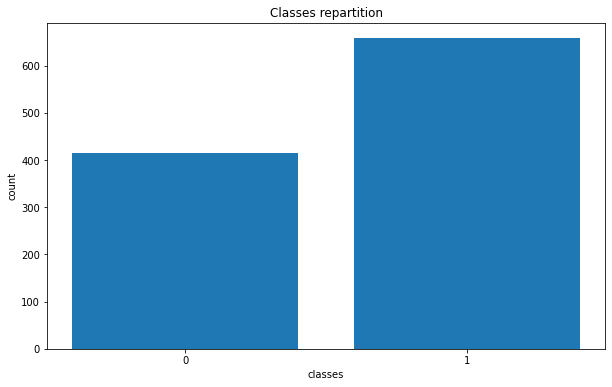

In [6]:
classes, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xticks(classes)
plt.xlabel('classes')
plt.ylabel('count')
plt.title('Classes repartition');

Class 0 is a bit under represented but it is not too imbalanced.

Let's have a look at the different features and their k score for feature selection.

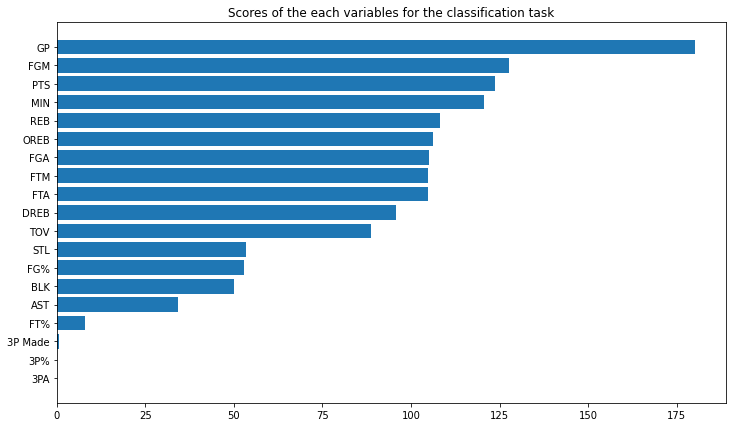

In [7]:
# normalize dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ideally this would be done after a split test / train
fs = SelectKBest()
fs.fit_transform(X_train_scaled, y_train)

sorted_scores_idx = np.argsort(fs.scores_)

plt.figure(figsize=(12, 7))
plt.barh(y=paramset[sorted_scores_idx], width=fs.scores_[sorted_scores_idx]);

plt.title('Scores of the each variables for the classification task');

Based on these results, we can choose to not include the last 3 features ```3P Made```, ```3PA``` and ```3P%```, which don't seem to be correlated to our label. We will also remove the percentages features since they don't provide more information than the number of attempts and the total of attempts made and they score lower than these two.

In [8]:
selected_features = np.argwhere(np.isin(paramset, ['GP', 'MIN', 'PTS', 'FGM', 'FGA',
                               'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV'])).ravel() #sorted_scores_idx[3:]
X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]
print(f'Selected features: {paramset[selected_features]}')


Selected features: ['GP' 'MIN' 'PTS' 'FGM' 'FGA' 'FTM' 'FTA' 'OREB' 'DREB' 'REB' 'AST' 'STL'
 'BLK' 'TOV']


On the rest of the study we'll only use these features.

### 3. Trying several models
Let's try to fit several classifiers which maximize our recall. It's also always interesting to have a look at the accuracy, as attributing all points to class 1 would yield a perfect recall score, but wouldn't really solve our problem. The $F_\beta$ score is also interesting in our case, its definition is the following:
$$
F_\beta = (1+\beta^2) \frac{\text{precision} \cdot \text{recall}}{\beta^2 \cdot \text{precision} + \text{recall}}
$$
By chosing $\beta = 2$ we can give more weight the recall score.

We'll have a look at all of these metrics while tunning our models, as well as diplaying the confusion matrix, which gives us a good overview of the performance of the model.

Let's perform a first test of our ```score_classifier``` function.

Recall : 78.40%
Accuracy : 69.68%
Fbeta : 77.41%


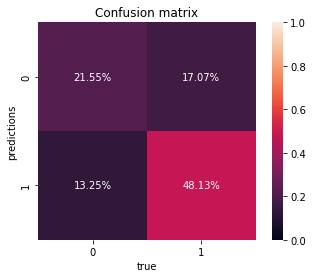

In [9]:
confusion_mat, recall, accuracy, fbeta = score_classifier(X_train_sel, SVC(), y_train)
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')

#### a. SVM classifier
Let's try to find the best ```C``` parameter for this classifier.

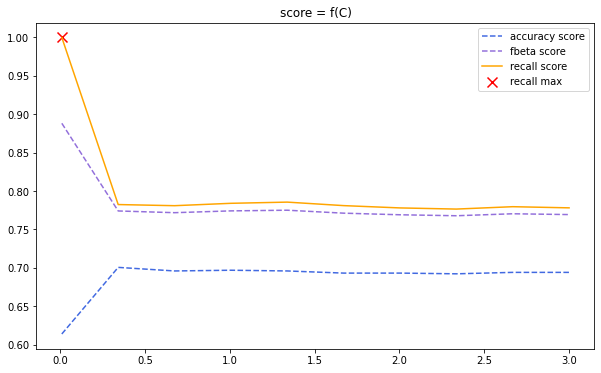

Value of C=0.01 provides the best recall score=100.00%, accuracy=61.38%, fbeta=88.82%


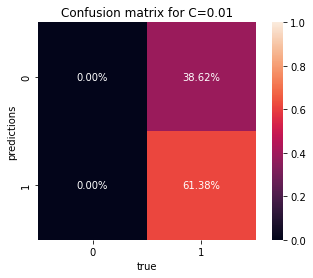

In [10]:
plot_scores_param(X_train_sel, SVC, y_train, 'C', np.linspace(0.01, 3, 10))

The lower value of C = 0.01 maximized the recall but in that case we simply attribute all points to the classe 1, which is not helpful. We should rather use a higher value of C, around 0.5 to compromise between the recall rate and the other metrics.

Recall : 80.35%
Accuracy : 73.88%
Fbeta : 80.16%


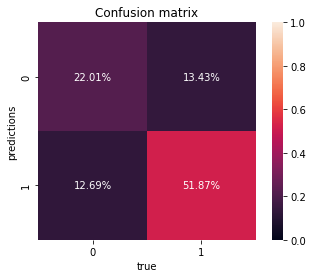

In [11]:
confusion_mat, recall, accuracy, fbeta = final_score_classifier(X_train_sel, y_train, X_test_sel, y_test, SVC(C=0.5))
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')
classifier_scores = classifier_scores.append({'Classifieur': 'SVC', 'recall': recall, 'accuracy': accuracy, 'fbeta': fbeta}, ignore_index=True)

This is a better comprimise between the recall rate and the accuracy.

#### b. Random Forest Classifier classifier
Let's try to find the best ```n_estimators``` value for this classifier.

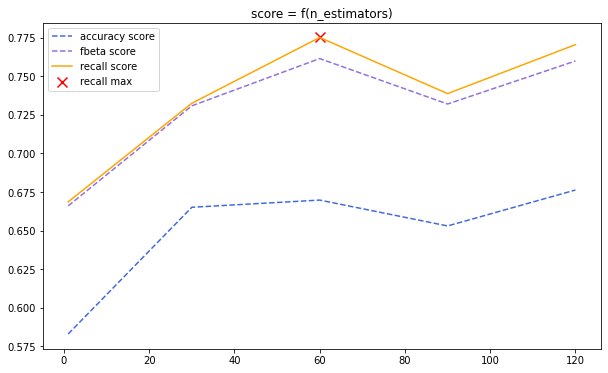

Value of n_estimators=60 provides the best recall score=77.52%, accuracy=66.98%, fbeta=76.15%


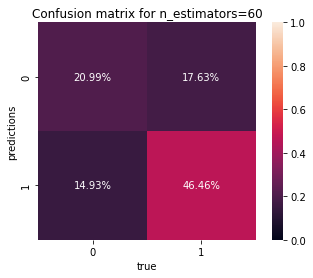

In [12]:
plot_scores_param(X_train_sel, RandomForestClassifier, y_train, 'n_estimators', [1, 30, 60, 90, 120], other_params={'max_samples': 0.8})

With this classifier we have a better balance between the recall rate and the accuracy, both seem to follow the same trend when changing the number of estimators. We can pick a value of ```n_estimators``` of 100.

Recall : 80.92%
Accuracy : 72.76%
Fbeta : 80.28%


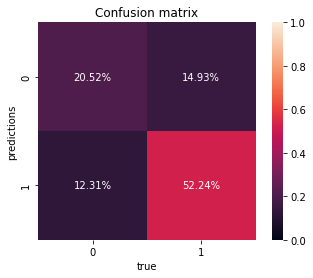

In [13]:
confusion_mat, recall, accuracy, fbeta = final_score_classifier(X_train_sel, y_train, X_test_sel, y_test, RandomForestClassifier(n_estimators=100))
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')
classifier_scores = classifier_scores.append({'Classifieur': 'RandomForestClassifier', 'recall': recall, 'accuracy': accuracy, 'fbeta': fbeta}, ignore_index=True)

#### c. K Nearest Neighbors classifier
We'll try to find the best ```n_neighbors``` value.

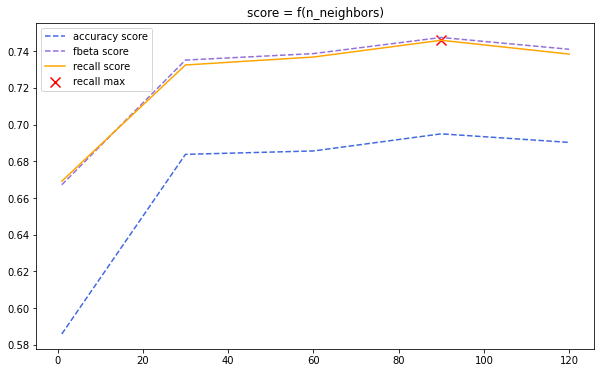

Value of n_neighbors=90 provides the best recall score=74.60%, accuracy=69.50%, fbeta=74.75%


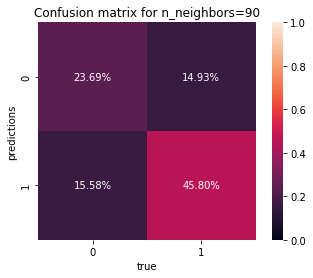

In [14]:
plot_scores_param(X_train_sel, KNeighborsClassifier, y_train, 'n_neighbors', [1, 30, 60, 90, 120])

Same as with the the Random Forest we have a good balance between the recall rate and the accuracy. We don't want a value of k too high, which increases biais, we can pick k around 100.

Recall : 73.99%
Accuracy : 70.52%
Fbeta : 74.94%


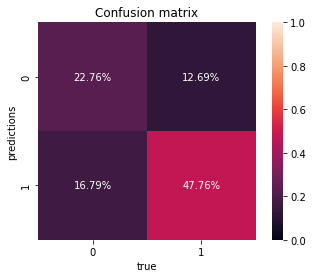

In [15]:
confusion_mat, recall, accuracy, fbeta = final_score_classifier(X_train_sel, y_train, X_test_sel, y_test, KNeighborsClassifier(n_neighbors=100))
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')
classifier_scores = classifier_scores.append({'Classifieur': 'KNeighborsClassifier', 'recall': recall, 'accuracy': accuracy, 'fbeta': fbeta}, ignore_index=True)

#### d. Logistic Regression classifier

This classifier is interesting because it allows us to add a weight to deal with the classes imbalance. We'll try to find the best value for ```class_weight``` for class 0.

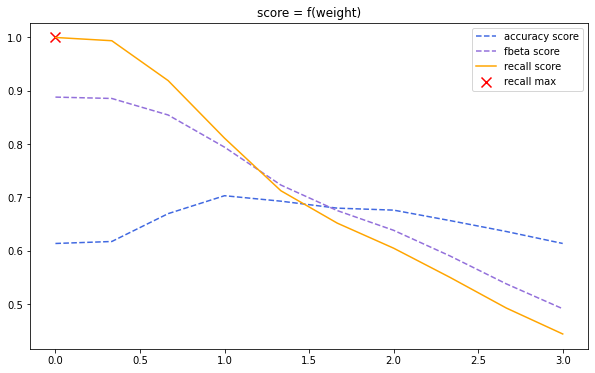

Value of weight=1e-05 provides the best recall score=100.00%, accuracy=61.38%, fbeta=88.82%


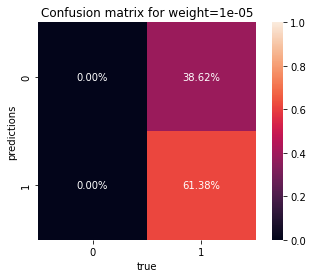

In [16]:
# we define a function to easily plug the LogisticRegression class to our utility functions
def logistic_regression_w(weight):
    return LogisticRegression(class_weight={0: weight}, max_iter=1e4)

plot_scores_param(X_train_sel, logistic_regression_w, y_train, 'weight', np.linspace(1e-5, 3, num=10))

Just like the SVM, we have our best score by just attributing all points to class 1, which is not what we want to achieve. Values of weight for class 0 between 0.5 and 1 seem to offer a good compromise between accuracy and recall. We'll pick a value of 0.7. We can also try to play on the parameter ```C``` of the Logistic Regression to play on the regularisation strength, let's try out.

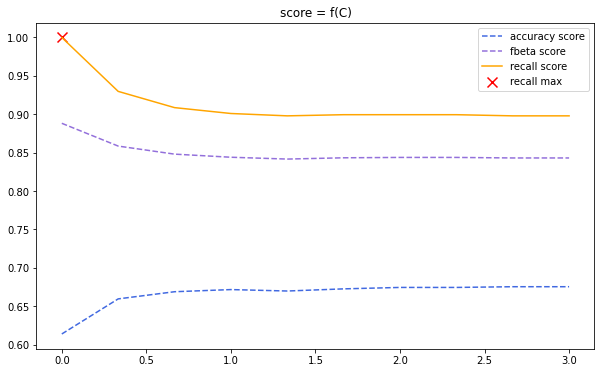

Value of C=1e-05 provides the best recall score=100.00%, accuracy=61.38%, fbeta=88.82%


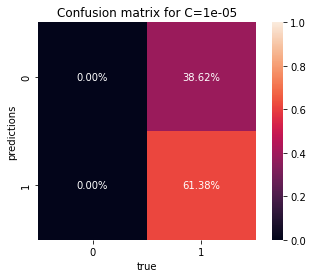

In [17]:
plot_scores_param(X_train_sel, LogisticRegression, y_train, 'C', np.linspace(1e-5, 3, num=10), other_params={'class_weight':{0: 0.7}, 'max_iter':1e4})

We observe the same kind of behavior as the SVM classifier. Values of C around 0.5 seem to offer a good compromise between recall and accuracy. We'll pick a value of 0.5.

Recall : 91.91%
Accuracy : 70.90%
Fbeta : 86.89%


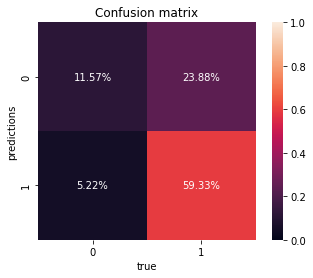

In [18]:
confusion_mat, recall, accuracy, fbeta = final_score_classifier(X_train_sel, y_train, X_test_sel, y_test, LogisticRegression(class_weight={0: 0.7}, C=0.5,  max_iter=1e4))
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')
classifier_scores = classifier_scores.append({'Classifieur': 'LogisticRegression', 'recall': recall, 'accuracy': accuracy, 'fbeta': fbeta}, ignore_index=True)

#### e. Naive Bayes classifier
We'll try to find the best value for ```var_smoothing```.

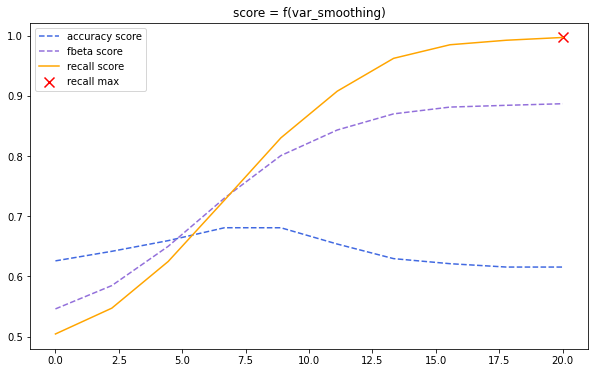

Value of var_smoothing=20.0 provides the best recall score=99.70%, accuracy=61.57%, fbeta=88.69%


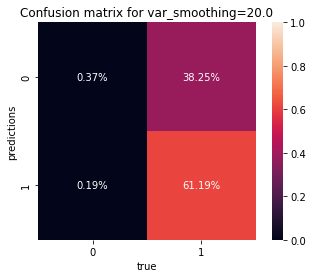

In [19]:
plot_scores_param(X_train_sel, GaussianNB, y_train, 'var_smoothing', np.linspace(1e-5, 20, num=10))

Here again we have our best score by just attributting all points to one class. Values of smoothing around 10 seem to offer a good compromise between precision and recall.

Recall : 90.75%
Accuracy : 71.27%
Fbeta : 86.26%


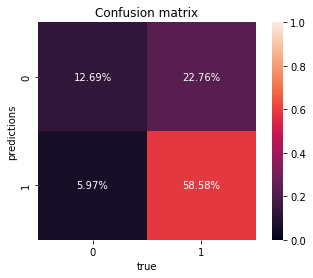

In [20]:
confusion_mat, recall, accuracy, fbeta = final_score_classifier(X_train_sel, y_train, X_test_sel, y_test, GaussianNB(var_smoothing=10))
#example of scoring with support vector classifier
plot_confusion_mat(confusion_mat)
print(f'Recall : {recall:.2%}')
print(f'Accuracy : {accuracy:.2%}')
print(f'Fbeta : {fbeta:.2%}')
classifier_scores = classifier_scores.append({'Classifieur': 'GaussianNB', 'recall': recall, 'accuracy': accuracy, 'fbeta': fbeta}, ignore_index=True)

### 4. Selecting a model

Let's have a look at the scores we obtained with our different models.

,Classifieur,recall,accuracy,fbeta
0,SVC,0.803468,0.738806,0.801615
1,RandomForestClassifier,0.809249,0.727612,0.802752
2,KNeighborsClassifier,0.739884,0.705224,0.749415
3,LogisticRegression,0.919075,0.708955,0.868852
4,GaussianNB,0.907514,0.712687,0.862637


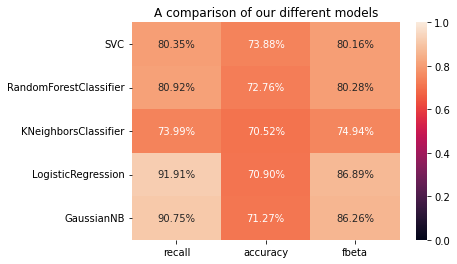

In [21]:
sns.heatmap(classifier_scores.iloc[:, 1:], yticklabels=classifier_scores.iloc[:, 0], vmax=1, vmin=0, annot=True, fmt='.2%')
plt.title('A comparison of our different models');

classifier_scores

The Logistic Regression and Gaussian NB models both seem like a good options, they both allow us to get high recall scores while keeping a reasonable accuracy. For this application we'll choose a Logistic Regression as we can tune the parameter of weight for class 0, which allows us to choose the best compromise between recall and accuracy.

Ultimately, the choice of accuracy vs recall comes down to the level risk that we are comfortable taking. By choosing a high recall score we want to make sure that we don't miss a potentially good players while accepting to potentially pick a player that will eventually not last more than 5 years. By giving a bit more importance to the accuracy we might miss out on some potentially good players. The compromises that we make should be chosen with carefull concertation with the end client to make sure that we offer him a level of risk that he is comfortable with.

Let's train our final model and export it. The final model will include a scaler to automatically scale input data.

In [22]:
model = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression(class_weight={0: 0.8}, C=0.5,  max_iter=1e4))])
model.fit(df_vals[:, selected_features], labels)

pickle.dump(model, open('players_classifier.pkl', 'wb'))